# Model Data Services (MDS)

This notebook is an early demonstration showing some of the benefit from having model data exposed via MDS (OPeNDAP).
Here, we explore model output without ever needing a copy of the data to be stored on the user's machine - instead, operations are generally lazy, and thus can minimise the amount of data requested from the upstream data provider.

In [2]:
import requests
from requests.compat import urljoin
from pprint import pprint, pformat

import warnings
warnings.filterwarnings('ignore')

In [3]:
import iris

iris.FUTURE.netcdf_promote = True

Get hold of the model instances stored on MDS.

In [4]:
endpoint = 'http://mdsapi-a:8082/instances/'
instances = requests.get(endpoint).json()

Now that we have them, figure out what forecast reference times (base dates) we have.

In [5]:
reference_dates = sorted(instance['baseDateTime'] for instance in instances)
print(reference_dates)

['2016-12-07T00:00:00Z', '2016-12-07T12:00:00Z', '2016-12-08T00:00:00Z', '2016-12-08T12:00:00Z']


In [6]:
instances[-1]

{'baseDateTime': '2016-12-08T12:00:00Z',
 'completed': False,
 'coord': {'baseTimeInSeconds': 43200,
  'family': 'ACCESS',
  'memberId': 0,
  'stream': 'APS2',
  'variant': 'ACCESS-G'},
 'definitionId': None,
 'ensembleId': '584999910e7eba02edf562d9',
 'id': '584999910e7eba02edf562da'}

Compute the DAP URLs that we can use to access the data:

In [7]:
files = requests.get('http://mdsapi-a:8082/files/?instanceid={}'
                     ''.format(instances[-1]['id'])).json()
dap_urls = sorted('http://mdsapi-a/thredds/dodsC/{}'
                  ''.format(resource['relativeUrl'])
                  for resource in files
                  if 'pressure' in resource['relativeUrl'])

In [8]:
print(len(dap_urls))
print(dap_urls[0])

53
http://mdsapi-a/thredds/dodsC/ACCESS/APS2/ACCESS-G/20161208120000/0/pressure/@all.0.20161208120000.000.nc4


Quickly take a peek to see what kind of data we actually have.

In [9]:
all_cubes = iris.load(dap_urls[0])
print(all_cubes)

0: vertical_velocity_geometric / (m s-1) (time: 1; pressure: 27; latitude: 769; longitude: 1024)
1: unknown_parameter_0_1_243_isobartic_surface / (1) (time: 1; pressure: 27; latitude: 769; longitude: 1024)
2: air_temperature / (K)               (time: 1; pressure: 27; latitude: 769; longitude: 1024)
3: dew_point_temperature / (K)         (time: 1; pressure: 27; latitude: 769; longitude: 1024)
4: geopotential_height / (m)           (time: 1; pressure: 27; latitude: 769; longitude: 1024)
5: x_wind / (m s-1)                    (time: 1; pressure: 27; latitude: 769; longitude: 1024)
6: y_wind / (m s-1)                    (time: 1; pressure: 27; latitude: 769; longitude: 1024)


And what vertical levels?

In [10]:
print(all_cubes[0].coord('pressure'))

DimCoord(array([  10000.,   15000.,   20000.,   25000.,   30000.,   35000.,
         40000.,   45000.,   50000.,   55000.,   60000.,   65000.,
         70000.,   75000.,   80000.,   82500.,   85000.,   87500.,
         90000.,   92500.,   95000.,   96250.,   97500.,   98500.,
         99000.,   99500.,  100000.]), standard_name=None, units=Unit('Pa'), long_name='pressure', var_name='pressure')


Let's get hold of all of the data.

In [11]:
t_1000hPa = iris.Constraint('air_temperature', pressure=100000)
cubes = iris.load_raw(dap_urls, t_1000hPa)

MDS is still in extremely early development, and it looks like some of the metadata is lacking a little in the time. Let's fix it up for now.

In [12]:
# Workaround badly formed frt/t
new_cubes = iris.cube.CubeList([])
for cube in cubes:
    t = cube.coord('time')
    frt = cube.coord('forecast_reference_time')
    fp = cube.coord('forecast_period')
    
    frt = frt.copy(points=frt.points + fp.points)
    t = t.copy(points=frt.points + fp.points)

    cube.remove_coord('forecast_reference_time')
    cube.remove_coord('time')
    
    cube.add_dim_coord(t, 0)
    cube.add_aux_coord(frt)
    
    # Normalise the attributes.
    for coord in cube.coords():
        coord.attributes = {}
    cube.attributes = {}
    
    new_cubes.append(cube[0])
cubes = new_cubes

In [13]:
air_temp = cubes.merge_cube()
print(air_temp)

air_temperature / (K)               (time: 53; latitude: 769; longitude: 1024)
     Dimension coordinates:
          time                           x             -               -
          latitude                       -             x               -
          longitude                      -             -               x
     Auxiliary coordinates:
          forecast_period                x             -               -
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          pressure: 100000.0 Pa


In [14]:
# Pick off the data upto 5 days
air_temp = air_temp.extract(iris.Constraint(forecast_period=lambda c: c.point <= 120))

In [15]:
print(air_temp)

air_temperature / (K)               (time: 41; latitude: 769; longitude: 1024)
     Dimension coordinates:
          time                           x             -               -
          latitude                       -             x               -
          longitude                      -             -               x
     Auxiliary coordinates:
          forecast_period                x             -               -
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          pressure: 100000.0 Pa


In [16]:
# Pick off the domain of interest
australian_domain = iris.Constraint(latitude=lambda c: -45 < c.point < -8,
                                    longitude=lambda c: 110 < c.point < 158)
access_g_aus = air_temp.extract(australian_domain)

In [17]:
print(access_g_aus)

air_temperature / (K)               (time: 41; latitude: 157; longitude: 137)
     Dimension coordinates:
          time                           x             -               -
          latitude                       -             x               -
          longitude                      -             -               x
     Auxiliary coordinates:
          forecast_period                x             -               -
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          pressure: 100000.0 Pa


So far, everything we have done has been done lazily by Iris. This means that, even though we loaded the *metadata* of all of the resources available, when it comes to fetching the actual data:

 * We only make a request for 41 OPeNDAP files (not the original 53) since we have subsetted the number of times we want
 * Within each of those 41 OPeNDAP files, we use subsetting to only request ~3% ((157\*137) / (769\*1024)) of the actual data array

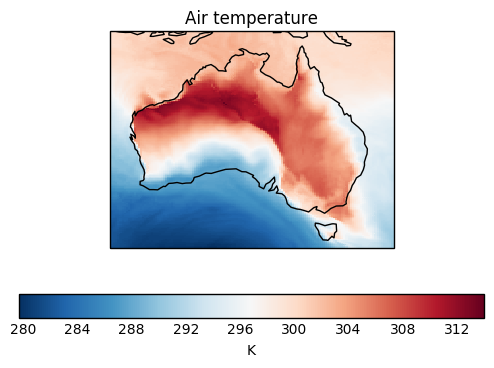

In [18]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

t_cube = access_g_aus[-1]

ax = plt.axes(projection=ccrs.PlateCarree(180))
qplt.pcolormesh(t_cube, cmap='RdBu_r')
ax.coastlines()
plt.show()

Let's tidy that plot up a bit, and let's look at the data in degrees centigrade.

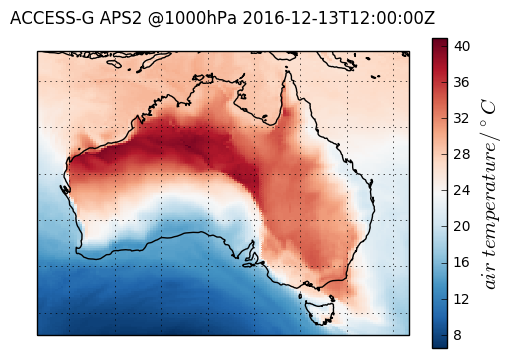

In [19]:
import iris.plot as iplt

ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.coastlines('50m')

t_cube.convert_units('degC')

iplt.pcolormesh(t_cube, cmap='RdBu_r')
plt.colorbar().set_label('$air \ temperature / ^\circ C$', size=15)

t = t_cube.coord('time')
dt = t.units.num2date(t.points[0])
plt.title('ACCESS-G APS2 @1000hPa {}Z\n'.format(dt.isoformat()))

ax.gridlines()

plt.show()

In [20]:
melbourne = [('longitude', 144.963056),
             ('latitude', -37.813611)]

In [21]:
print(access_g_aus)

air_temperature / (K)               (time: 41; latitude: 157; longitude: 137)
     Dimension coordinates:
          time                           x             -               -
          latitude                       -             x               -
          longitude                      -             -               x
     Auxiliary coordinates:
          forecast_period                x             -               -
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          pressure: 100000.0 Pa


Let's interpolate to get the data at one location (because iris is not currently lazy, *all* of the data from `access_g_aus` will be retrieved):

In [22]:
from iris.analysis import Linear
melbourne_air_temp = access_g_aus.interpolate(melbourne, Linear())
print(melbourne_air_temp)

air_temperature / (K)               (time: 41)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          latitude: -37.813611 degrees
          longitude: 144.963056 degrees
          pressure: 100000.0 Pa


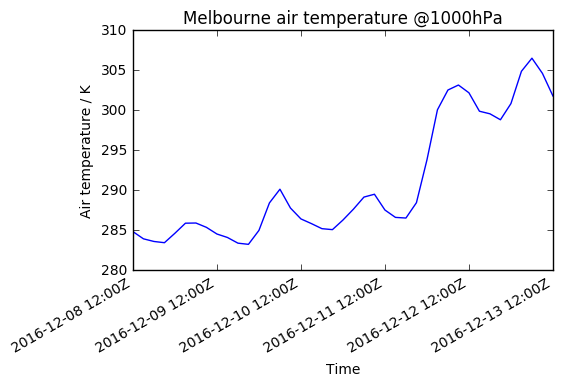

In [23]:
import matplotlib.dates as mdates

ax = plt.axes()
qplt.plot(melbourne_air_temp)
plt.title('Melbourne air temperature @1000hPa')

# Tidy up the date ticks.
plt.subplots_adjust(bottom=0.3, left=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%MZ'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.setp(ax.xaxis.get_ticklabels(), rotation=30, horizontalalignment='right')

plt.show()

In [24]:
# We could choose to save the cube (and thereby get the data from the OPeNDAP server) 
iris.save(access_g_aus, 'aus_air_temperature.nc')

Instead of interpolating to the desired point, we could equally request the nearest grid point to the requested location.
Because indexing is lazy within iris, this operation does not yet fetch *any* data from the OPeNDAP service, and when we do request it, it will only fetch the 41 data values that have been requested:

In [25]:
melbourne_index = iris.analysis.interpolate.nearest_neighbour_indices(access_g_aus, melbourne)
print(melbourne_index)

near_melbourne = access_g_aus[melbourne_index]

near_melbourne.convert_units('degC')

(slice(None, None, None), 126, 99)


In [26]:
print(near_melbourne)

air_temperature / (degC)            (time: 41)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          latitude: -37.734375 degrees
          longitude: 144.843956 degrees
          pressure: 100000.0 Pa


Now, let's take a look at the min/max air temperature in any 24hr period. Here we use the fact that our data is defined at a 3hr interval:

In [27]:
print(near_melbourne.rolling_window('time', iris.analysis.MAX, 8))

air_temperature / (degC)            (time: 34)
     Dimension coordinates:
          time                           x
     Auxiliary coordinates:
          forecast_period                x
     Scalar coordinates:
          forecast_reference_time: 2016-12-08 12:00:00
          latitude: -37.734375 degrees
          longitude: 144.843956 degrees
          pressure: 100000.0 Pa
     Cell methods:
          maximum: time


Visualising this:

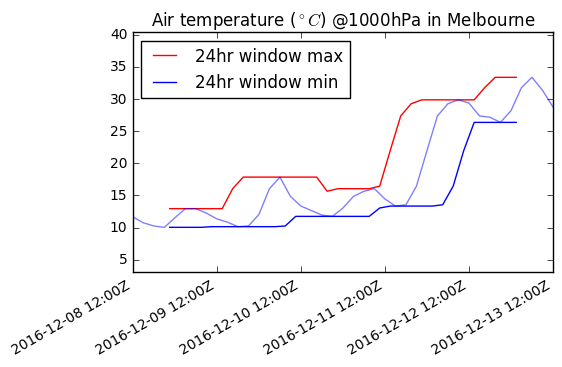

In [28]:
ax = plt.axes()

plt.title("Air temperature ($^\circ C$) @1000hPa in Melbourne")
iplt.plot(near_melbourne.rolling_window('time', iris.analysis.MAX, 8),
          label='24hr window max', color='red')
iplt.plot(near_melbourne.rolling_window('time', iris.analysis.MIN, 8),
          label='24hr window min', color='blue')

iplt.plot(near_melbourne, alpha=0.5)

plt.legend(loc='top left')
plt.margins(0, 0.3)

# Tidy up the date ticks.
plt.subplots_adjust(bottom=0.3, left=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%MZ'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.setp(ax.xaxis.get_ticklabels(), rotation=30, horizontalalignment='right')

plt.show()